# Classification with undersampled data 

In [1]:

import h5py
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import sklearn
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# read in data

data = pd.read_csv(r"C:\Users\hien\Desktop\masterdata\creditcard.csv")

## Data preprocessing

In [3]:
# Split into training and validation set
x = data.iloc[:,:-1]      # dataframe without class feature
y = data.iloc[:,-1]       # selecting only class feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))


Training - fraud case: 0.17%
Testing - fraud case: 0.17%


In [4]:
print("# Fraud in training: ", np.sum(y_train==1))
print("# Non-fraud in training: ", np.sum(y_train==0))
print("# Fraud in testing: ", np.sum(y_test==1))
print("# Non-fraud in testing: ", np.sum(y_test==0))

# Fraud in training:  394
# Non-fraud in training:  227451
# Fraud in testing:  98
# Non-fraud in testing:  56864


In [5]:
#scaling time and amount to prevent data leakage

sc_time = RobustScaler()
sc_time.fit(x_train.iloc[:,0:1])
x_train.iloc[:,0:1] = sc_time.transform(x_train.iloc[:,0:1])
x_test.iloc[:,0:1] = sc_time.transform(x_test.iloc[:,0:1])

sc_amount = RobustScaler()
sc_amount.fit(x_train.iloc[:,-1:])
x_train.iloc[:,-1:] = sc_amount.transform(x_train.iloc[:,-1:])
x_test.iloc[:,-1:]= sc_amount.transform(x_test.iloc[:,-1:])

C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [6]:
# Split training set into sub-training set for undersampling and validation set to prevent data leakage
x_subtrain, x_val, y_subtrain, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [7]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks

In [8]:

# Undersampling majority class using random undersampler and training set is used for validation during training

undersamp = RandomUnderSampler(sampling_strategy='majority')
#undersamp = NearMiss(version=1, n_neighbors=3)
#undersamp = CondensedNearestNeighbour(n_neighbors=1)
#undersamp = TomekLinks()

x_subtrain_undersamp, y_subtrain_undersamp = undersamp.fit_resample(x_subtrain, y_subtrain)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_subtrain_undersamp==1)/len(y_subtrain_undersamp)))
print ("Percentage of cases with class 1 for testing:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for testing:0.0017 



In [9]:
#print ("# Fraud in training: ", np.sum(y_subtrain_undersamp==1))
#print ("# Non-fraud in training: ", np.sum(y_subtrain_undersamp==0))
#print ("# Fraud in testing: ", np.sum(y_test==1))
#print ("# Non-fraud in testing: ", np.sum(y_test==0))

print ("# Fraud in training: ", np.sum(y_subtrain_undersamp==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain_undersamp==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))

# Fraud in training:  326
# Non-fraud in training:  326
# Fraud in validation:  68
# Non-fraud in validation:  45501
# Fraud in test:  98
# Non-fraud in test:  56864


## SVM

In [10]:
#Import svm model
from sklearn import svm

In [18]:
#Create a svm Classifier
classifier_svm = svm.SVC(kernel='linear') # Linear Kernel

In [19]:
#Train the model using the training sets
classifier_svm.fit(x_subtrain_undersamp, y_subtrain_undersamp)


SVC(kernel='linear')

In [20]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc

In [21]:
#Predict the response for test dataset

y_pred_svm = classifier_svm.predict(x_test)

cm = confusion_matrix(y_test, y_pred_svm)
print ("Confusion matrix:\n", cm)
print ("\n")

precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)

print ("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_svm)))
print ("precision: {:.2f}".format(precision_score(y_test, y_pred_svm)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred_svm)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred_svm)))
print ("Average precision: {:.2f}".format(average_precision_score(y_test, y_pred_svm)))
print ("AUC-ROC: {:.2f}".format(roc_auc_score(y_test, y_pred_svm)))

auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)

Confusion matrix:
 [[55007  1857]
 [   10    88]]


accuracy: 0.97
precision: 0.05
recall: 0.90
f1 score: 0.09
Average precision: 0.04
AUC-ROC: 0.93
Logistic PR AUC: 0.472


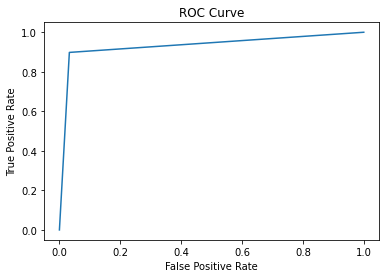

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
# plot the roc curve for the model

plt.plot(fpr, tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
#plt.legend()
# show the plot
plt.show()

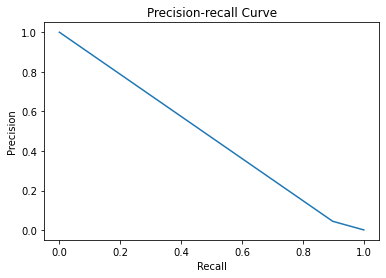

In [23]:
plt.plot(recall, precision)
plt.title("Precision-recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()